In [1]:
%matplotlib inline

#puts above directory into the path
import sys
sys.path.append("../../VREP_robot")
sys.path.append("../../VREP_robot/utils")
sys.path.append("../")
import vrep
from vrepRobot import *

from forwardKinematics import robot_config
import numpy as np
import time

pi = np.pi

In [2]:
# setup environment
myRobot = robot_config()
vrep_env = VREP_Environement(synchronous=True)
ik_handles = ['ik_joint1', 'ik_joint2', 'ik_joint3', 'ik_joint4', 'ik_joint5', 'ik_joint6', 'ik_joint7', 'ik_ee', 'kinematicsTest_IKTip', 'ik_rf7_static']
vrep_env.add_robot(VREP_Robot('ik_robot', ik_handles, connection_type = 'nonblocking'))
vrep_env.start_simulation()

Connected to remote API server
In synchronous mode
1 robot(s) connected: ['ik_robot']


# prepare training set
joint_range_lower_limit = np.array([-7.500e-2, -4.500e-2, -9.000e+1, -5.200e+1, -5.020e+1, -5.200e+1, 0])
joint_range = np.array([1.500e-1, 9.000e-2, 1.800e+2, 1.040e+2, 1.020e+2, 1.040e+2, 5.500e-2])
joint_range_upper_limit = joint_range_lower_limit + joint_range
joint_range_upper_limit

In [8]:
# generate config samples
from configGenerator_VREP import configGenerator_VREP
config = configGenerator_VREP.generate_sample(12)  # set sample number here
total_config = config.shape[0]
print("total configs = ", total_config)
#print(config)
print(total_config/50/3600)

total configs =  2985984
16.5888


In [9]:
# initialize collision state placeholder
y = np.zeros((total_config))
EEPosition = np.zeros((total_config,3))
#EEorientation = np.zeros((total_config,3))
EEQuaternion = np.zeros((total_config,4))

In [14]:
# get collision handle
vrep_env.ik_robot.getCollisionHandle('Collision')
vrep.simxSynchronousTrigger(vrep_env.clientID)
vrep.simxGetPingTime(vrep_env.clientID)

time.sleep(10)

True

In [15]:
# collision detect
from tqdm import tqdm_notebook as tqdm

pbar = tqdm(total=total_config)  # set progress bar

t = time.clock()
for i in range(total_config):
#for i in range(len(jointAngle)):
    joint_angle = config[i, :]
    for j in range(6):
        vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[j], joint_angle[j])
    #vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[5], jointAngle[i])
    
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    vrep.simxGetPingTime(vrep_env.clientID)
    collisionState = vrep_env.ik_robot.getCollisionState()
    y[i] = collisionState
    #vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEQuaternion[i,:] = vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    pbar.update(1)
    #time.sleep(0.5)
    #print(EEPosition[i,:])
    
    if i%int(total_config/100+1) == 0:
        Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEQuaternion))
        #np.save('logs/CollisionData{}.npy'.format(i),Data)
    
pbar.close()
print('runtime = ', time.clock()-t)  
# print('collision state = ', y)
print('EEposition\n', EEPosition)
# print('EEorientation\n', EEorientation)

KeyboardInterrupt: 

In [7]:
# save data
Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEQuaternion))
print(Data)
np.save('CollisionData.npy',Data)

[[-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
  -5.02000000e+01 -5.20000000e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
  -5.02000000e+01  5.20000000e+01  0.00000000e+00  5.24759293e-04
   1.36315823e-03 -7.46536255e-03  1.70437470e-01 -1.98538378e-01
  -4.46386002e-02  9.64127064e-01]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
   5.18000000e+01 -5.20000000e+01  0.00000000e+00  1.00774765e-02
  -3.01173329e-02 -1.14361644e-02  2.74960786e-01  2.24062413e-01
  -1.83228239e-01  9.16853368e-01]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
   5.18000000e+01  5.20000000e+01  0.00000000e+00  3.36551666e-03
  -4.25913930e-03 -7.85839558e-03 -5.80356717e-02 -1.13270253e-01
   5.71611464e-01  8.10593724e-01]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01  5.20000000e+01
  

   5.52891910e-01  8.22354674e-01]]


In [19]:
loadedData = np.load('CollisionData.npy')
print(loadedData)

[[-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
  -5.02000000e+01 -5.20000000e+01  0.00000000e+00 -3.58089089e-01
  -9.13624823e-01 -2.52609968e+00  6.75879344e-02 -2.08656847e-01
  -6.75620317e-01 -7.03868985e-01]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
  -5.02000000e+01  5.20000000e+01  0.00000000e+00 -3.58089089e-01
  -9.13624823e-01 -2.52609968e+00  6.75879344e-02 -2.08656847e-01
  -6.75620317e-01 -7.03868985e-01]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
   5.18000000e+01 -5.20000000e+01  1.00000000e+00 -3.58089089e-01
  -9.13624823e-01 -2.52609968e+00  6.75879344e-02 -2.08656847e-01
  -6.75620317e-01 -7.03868985e-01]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01 -5.20000000e+01
   5.18000000e+01  5.20000000e+01  0.00000000e+00 -3.58089089e-01
  -9.13624823e-01 -2.52609968e+00  6.75879344e-02 -2.08656847e-01
  -6.75620317e-01 -7.03868985e-01]
 [-7.50000000e-02 -4.50000000e-02 -9.00000000e+01  5.20000000e+01
  

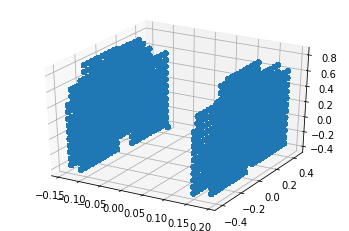

In [16]:
# plot

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(EEPosition[:,0], EEPosition[:,1], EEPosition[:,2])
plt.show()

In [76]:
# test
# for i in range(100):
#     joint_angle = np.sin(i*2*np.pi/100)*np.pi/4
#     vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[5], joint_angle)
#     vrep.simxSynchronousTrigger(vrep_env.clientID)
#     vrep.simxGetPingTime(vrep_env.clientID)
#     collisionState = vrep_env.ik_robot.getCollisionState()
#     print(collisionState)

In [13]:
np.unique(y)

array([0.])